In [1]:
from helper_functions import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

In [2]:
import pathlib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, experimental, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import argparse
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from helper_functions import *

In [3]:
root = 'Dataset/Monkey_Dataset'
train_directory = pathlib.Path(f'{root}/training/training/')
test_directory = pathlib.Path(f'{root}/validation/validation/')

columns = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
category_df = pd.read_csv(f"{root}/monkey_labels.txt", names=columns, skiprows=1)
category_df
categories = category_df['Common Name']
n_categories = len(categories)


In [4]:
height = 224
width = 224
batch_size = 32

trdata = ImageDataGenerator(rescale=1. / 255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)
training_data = trdata.flow_from_directory(
    train_directory,
    target_size=(height, width),
    batch_size=batch_size,
    shuffle=True,
    subset='training',
    class_mode='categorical'
)

valdata = ImageDataGenerator(validation_split=0.2,
    rescale=1./255)
validation_data = valdata.flow_from_directory(
    train_directory,
    target_size=(height, width),
    subset='validation',
    class_mode='categorical'
)

testdata = ImageDataGenerator(rescale=1./255)
test_data = testdata.flow_from_directory(
    test_directory,
    target_size=(height, width),
    class_mode='categorical'
)


Found 881 images belonging to 10 classes.
Found 217 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [58]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

model = Sequential([
    layers.Conv2D(32, 3, activation='relu', strides=(2,2), input_shape=(height, width, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, strides=(2,2), activation='relu'),
    layers.BatchNormalization(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, strides=(2,2), activation='relu'),

    layers.Conv2D(512, 1, strides=(2,2), activation='relu'),

    layers.Conv2D(n_categories, 1),

    layers.GlobalAveragePooling2D(),

    layers.Activation('softmax')
])

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

epochs = 100
model.summary()

history = model.fit(training_data, validation_data=validation_data, epochs=epochs)#, callbacks=[callback])

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_83 (Conv2D)          (None, 74, 74, 32)        896       
                                                                 
 batch_normalization_53 (Bat  (None, 74, 74, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_84 (Conv2D)          (None, 36, 36, 32)        9248      
                                                                 
 batch_normalization_54 (Bat  (None, 36, 36, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_85 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 batch_normalization_55 (Bat  (None, 34, 34, 64)     

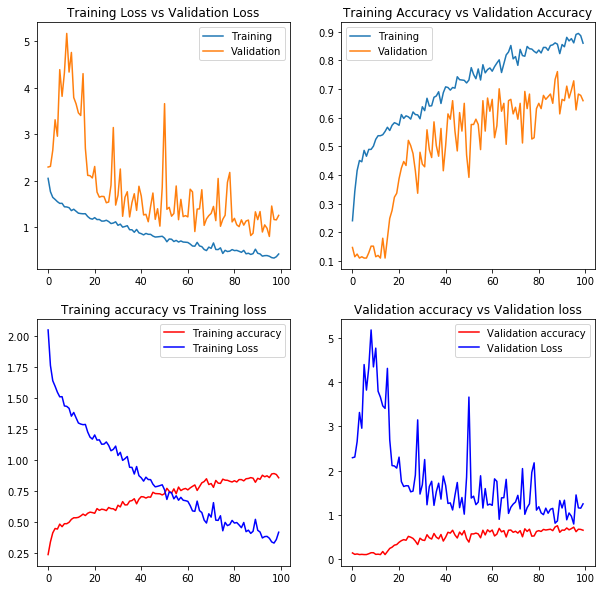

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

axs[0,0].plot(loss)
axs[0,0].plot(val_loss)
axs[0,0].title.set_text('Training Loss vs Validation Loss')
axs[0,0].legend(['Training', 'Validation'])

axs[0,1].plot(acc)
axs[0,1].plot(val_acc)
axs[0,1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[0,1].legend(['Training', 'Validation'])

axs[1,0].plot(epochs, acc, 'r', label='Training accuracy')
axs[1,0].plot(epochs, loss, 'b', label='Training Loss')
axs[1,0].title.set_text('Training accuracy vs Training loss')
axs[1,0].legend(loc=0)

axs[1,1].plot(epochs, val_acc, 'r', label='Validation accuracy')
axs[1,1].plot(epochs, val_loss, 'b', label='Validation Loss')
axs[1,1].title.set_text('Validation accuracy vs Validation loss')
axs[1,1].legend(loc=0)


In [60]:
score = model.evaluate(test_data)

9/9 [==============================] - 2s 241ms/step - loss: 1.2346 - accuracy: 0.6801


In [62]:
pred = model.predict(test_data, verbose=1)
pred = np.argmax(pred, axis=1)

9/9 [==============================] - 2s 208ms/step


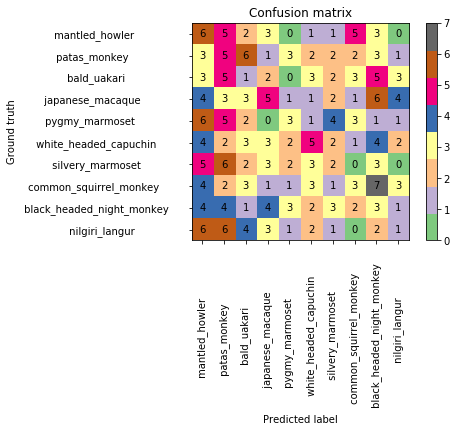

In [64]:
conf_mat = confusion_matrix(y_true=test_data.labels, y_pred=pred)
plt.imshow(conf_mat, cmap=plt.cm.Accent)
indexes = np.arange(len(categories))
for i in indexes:
    for j in indexes:
        plt.text(j, i, conf_mat[i, j], 
                horizontalalignment='center', 
                verticalalignment='center')

plt.colorbar()
plt.xticks(indexes, categories, rotation=90)   
plt.xlabel('Predicted label')
plt.yticks(indexes, categories)
plt.ylabel('Ground truth')
plt.title('Confusion matrix')
plt.show()

In [65]:
from sklearn.metrics import classification_report
ground = test_data.labels
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.13      0.23      0.17        26
           1       0.12      0.18      0.14        28
           2       0.04      0.04      0.04        27
           3       0.20      0.17      0.18        30
           4       0.19      0.12      0.14        26
           5       0.22      0.18      0.20        28
           6       0.10      0.08      0.09        26
           7       0.15      0.11      0.12        28
           8       0.08      0.11      0.09        27
           9       0.06      0.04      0.05        26

    accuracy                           0.12       272
   macro avg       0.13      0.12      0.12       272
weighted avg       0.13      0.12      0.12       272

